In [2]:
from qiskit import QuantumCircuit
import numpy as np 
import scipy
import pandas as pd
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi
from qiskit import Aer
import post_processing as pp
import qutip as qtp
import random as random
import hamiltonian_class_package as hcp 
from tqdm.notebook import tqdm
import pickle
import os

identity = np.array([(1,0),(0,1)],dtype=np.complex128)
sigma_x = np.array([(0,1),(1,0)],dtype=np.complex128)
sigma_y = np.array([(0,-1j),(1j,0)],dtype=np.complex128)
sigma_z = np.array([(1,0),(0,-1)],dtype=np.complex128)
sigmas = [identity, sigma_x, sigma_y,sigma_z]

In [3]:
def isToPs(index_string):
    '''
    converts an index string like "123" to the corresponding pauli string: sx otimes sy otimes sz
    '''
    first_matrix = sigmas[int(index_string[0])]
    matrix = first_matrix
    for j in index_string[1:]:
        matrix = np.kron(matrix, sigmas[int(j)])
    return matrix

def total_sz_opr(numQubits):
    op = isToPs("3" + "0"*(numQubits-1))
    for i in range(1,numQubits):
        indexStr = "0"*i +"3" + "0"*(numQubits-i-1)
        # print(indexStr)
        op += isToPs(indexStr)
    return op


# def generate_two_qubit_N_operator(theta):
#     hermitian_op = np.kron(sigma_x,sigma_x)
#     hermitian_op += np.kron(sigma_y,sigma_y)
#     hermitian_op += np.kron(sigma_z,sigma_z)
#     hermitian_op *= 1j*theta
#     unitary_mat = scipy.linalg.expm(hermitian_op)
#     op = qi.Operator(unitary_mat)
#     return op

def generate_two_qubit_N_operator(theta):
    '''
    somehow this is diff from the commented out one above lol ohwell

    this is from Abol's paper
    '''
    qc = QuantumCircuit(2, name = "N({theta})".format(theta = theta))
    qc.rz(np.pi/2,1)
    qc.cx(1,0)
    qc.rz(2*theta - np.pi/2, 0)
    qc.ry(np.pi/2 - 2*theta, 1)
    qc.cx(0,1)
    qc.ry(2*theta - np.pi/2, 1)
    qc.cx(1,0)
    qc.rz(-np.pi/2,0)

    return qi.Operator(qc)

def create_combined_N_circuit(numQubits,params):
    '''
    numQubits must be an even integer
    '''
    N_gates_params = params[:numQubits-1]
    phase_gate_params = params[numQubits-1:]
    qc = QuantumCircuit(numQubits)
    layer1 = list(range(0,numQubits,2))
    layer2 = list(range(1,numQubits-1,2))
    combined = layer1.copy()
    combined.extend(layer2)
    counter = 0
    for i in combined:
        theta = N_gates_params[counter]
        op = generate_two_qubit_N_operator(theta)
        qc.unitary(op,[i,i+1], label="N({theta})".format(theta=theta))
        counter += 1
    qc.barrier()
    for j in range(numQubits):
        phi = phase_gate_params[j]
        qc.p(phi,j)
    return qc 

def circuitToSampleFrom(numQubits, sz, params):
    qc = QuantumCircuit(numQubits)
    numOnes = int(0.5*(numQubits-sz))
    # for i in range(numOnes):
    #     qc.x(i)

    #everytime this is run, choose diff starting state
    for i in random.sample(range(numQubits), numOnes):
        qc.x(i)
    qc.barrier()
    toAppend = create_combined_N_circuit(numQubits, params)
    to_return = qc.compose(toAppend)
    qc.draw()
    return to_return


def generate_n_random_states(numQubits, sz, numStates):
    rng = np.random.default_rng(seed=100) 
    states = []
    for i in range(numStates):
        params = rng.uniform(0,2*np.pi,2*numQubits-1)
        circuit = circuitToSampleFrom(numQubits, sz, params)
        backend = Aer.get_backend("statevector_simulator")
        job = backend.run(circuit)
        result = job.result()
        outputstate = result.get_statevector(circuit)
        outputstate = np.array(outputstate)
        states.append(outputstate)
        # total_sz = total_sz_opr(numQubits)
        # # print(result.get_statevector(circuit, decimals =4))
        # print(outputstate.conj().T@total_sz@outputstate)
    return states

def generate_XXZ_hamiltonian(num_qubits, delta):
    #epsilon = 0.5
    if num_qubits == 1:
        raise(RuntimeError('Cannot generate Hamiltonian with 1 qubit'))
    else:
        hamiltonian = hcp.heisenberg_xyz_model(num_qubits, jx = 1, jy = 1, jz = delta)
    return hamiltonian

def generate_bulk_dephasing(num_qubits):
    gammas = []
    L_terms = []
    if num_qubits == 1:
        raise(RuntimeError("One qubit case not considered"))
    else:
        for i in range(num_qubits):
            pauli_string_deconstructed = ["0"]*num_qubits
            pauli_string_deconstructed[i] = "3"
            pauli_string_str = "".join(pauli_string_deconstructed)
            L_i = hcp.generate_arbitary_hamiltonian(num_qubits, [1], [pauli_string_str])
            # print(L_i.to_matrixform())
            gammas.append(1)
            L_terms.append(L_i)
    return (gammas, L_terms)

def generate_total_magnetisation_matform(num_qubits):
    def make_sigma_z_string(i):
        pauli_string_deconstructed = ["0"]*num_qubits
        pauli_string_deconstructed[i] = "3"
        pauli_string_str = "".join(pauli_string_deconstructed)
        return pauli_string_str
    p_strings = [make_sigma_z_string(i) for i in range(num_qubits)]
    betas = [1 for i in range(num_qubits)]
    M = hcp.generate_arbitary_hamiltonian(num_qubits, betas, p_strings)
    return M.to_matrixform()

def evaluate_rho_dot(rho, hamiltonian_mat, gammas, L_terms, L_dag_L_terms):
    coherent_evo = -1j * (hamiltonian_mat @ rho - rho @ hamiltonian_mat)
    quantum_jumps_total = 0 + 0*1j
    for i in range(len(gammas)):
        gamma_i = gammas[i]
        L_i_mat = L_terms[i]
        L_i_dag_L_i = L_dag_L_terms[i]
        anti_commutator = L_i_dag_L_i @ rho + rho @ L_i_dag_L_i
        jump_term = L_i_mat @ rho @ L_i_mat.conj().T
        quantum_jumps_total += gamma_i * (jump_term - 0.5*anti_commutator)
    return coherent_evo + quantum_jumps_total


dir_name = "abolCircuitPickedObjs"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

def save_obj(obj, name):
    #name is a string
    with open(dir_name +'/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    #name is a string
    with open(dir_name +'/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
def symmetrySubspaceDim(numQubits, sz):
    M_matform = generate_total_magnetisation_matform(numQubits)
    M_eigvals, M_eigvecs = scipy.linalg.eigh(M_matform)

    projector_indices = np.where(M_eigvals==sz)[0]
    projector = M_eigvecs[:,projector_indices] #fancy indexing

    maximally_mixed_state = np.eye(len(projector_indices)) * 1/len(projector_indices)
    print("dimension of symmetry subspace is", len(projector_indices))

    return 

In [5]:

def calcFidelity(numQubits, numAnsatzStates, sz, verbose = False, precompMatrices=False):
    ansatz = generate_n_random_states(numQubits, sz, numAnsatzStates)

    H = generate_XXZ_hamiltonian(numQubits, 0.3).to_matrixform() #xxx hamiltonian
    gammas,L_terms_uneval = generate_bulk_dephasing(numQubits)
    L_terms = [L.to_matrixform() for L in L_terms_uneval]
    L_dag_L_terms = []
    for Li in L_terms:
        L_dag_L = Li.conj().T @ Li
        L_dag_L_terms.append(L_dag_L)

    E_matrix = np.zeros(shape=[numAnsatzStates,
    numAnsatzStates],dtype=np.complex128)

    D_matrix = np.zeros(shape=[numAnsatzStates,
    numAnsatzStates],dtype=np.complex128)

    R_mats = [np.zeros(shape=[numAnsatzStates,
    numAnsatzStates],dtype=np.complex128) for i in L_terms]

    F_mats = [np.zeros(shape=[numAnsatzStates,
    numAnsatzStates],dtype=np.complex128) for i in L_dag_L_terms]

    if precompMatrices == False:
        if verbose:
            print("Generating matrices...")
        for i in tqdm(range(len(ansatz))):
            for j in range(len(ansatz)):
                bra = ansatz[i].conj().T
                ket = ansatz[j]
                E_matrix[(i,j)] = bra@ket
                D_matrix[(i,j)] = bra @ H @ ket 
                for k in range(len(R_mats)):
                    R_k_mat = R_mats[k]
                    F_k_mat = F_mats[k]

                    R_k_mat[(i,j)] = bra@L_terms[k]@ket
                    F_k_mat[(i,j)] = bra @ L_dag_L_terms[k] @ ket
        to_save = (D_matrix,E_matrix,R_mats,F_mats,gammas)
        save_obj(to_save, "precomputedMatrices{}qubits".format(str(numQubits)))
    else:
        to_load = load_obj("precomputedMatrices{}qubits".format(str(numQubits)))
        D_matrix,E_matrix,R_mats,F_mats,gammas = to_load

    ######################################
    # Start of classical post-processing #
    ######################################
    ness_problem_instance = pp.IQAE_Lindblad(numQubits, D_matrix, E_matrix, R_matrices=R_mats, F_matrices=F_mats, gammas = gammas)

    M_matform = generate_total_magnetisation_matform(numQubits)
    print(len(M_matform))

    M_eigvals, M_eigvecs = scipy.linalg.eigh(M_matform)

    # M_eigvals, M_eigvecs = load_obj("{}qubitsM_eigh".format(str(numQubits)))

    projector_indices = np.where(M_eigvals==sz)[0]
    projector = M_eigvecs[:,projector_indices] #fancy indexing
    eigh_inv_cond = 10**(-6)
    eig_inv_cond = 10**(-6)
    use_qiskit = False
    degeneracy_tol = 5
    sdp_tolerance_bound = 0

    ness_problem_instance.define_optimizer('feasibility_sdp',eigh_invcond=eigh_inv_cond,eig_invcond=eig_inv_cond,degeneracy_tol=degeneracy_tol,sdp_tolerance_bound=sdp_tolerance_bound)

    if verbose:
        print("starting SDP")
    ness_problem_instance.evaluate()
    if verbose:
        print("SDP finished")

    beta_mat = ness_problem_instance.get_density_matrix_results()[0]

    rho = np.zeros(shape=(2**numQubits, 2**numQubits),dtype=np.complex128) 
    for i in range(len(ansatz)):
        for j in range(len(ansatz)):
            ket_i = ansatz[i].reshape(len(ansatz[i]),1)
            bra_j = (ansatz[j].reshape(len(ansatz[i]),1)).conj().T
            rho += beta_mat[(i,j)] * ket_i @ bra_j

    rho_reduced = projector.conj().T @ rho @ projector 
    maximally_mixed_state = np.eye(len(projector_indices)) * 1/len(projector_indices)
    print("dimension of symmetry subspace is", len(projector_indices))

    # print("eigvals of M are", M_matform)
    # print("eigvals of rho are", scipy.linalg.eigvalsh(rho))
    # print("trace of rho is", np.trace(rho))

    print("tr(M*rho)=", np.trace(M_matform@rho))
    # rho_dot = evaluate_rho_dot(rho, H, gammas, L_terms, L_dag_L_terms)

    # print("Max value of rho_dot is", np.max(np.max(rho_dot)))
    #fidelity computation

    qtp_rho_reduced = qtp.Qobj(rho_reduced)
    qtp_maximally_mixed_state = qtp.Qobj(maximally_mixed_state)
    fidelity = qtp.metrics.fidelity(qtp_rho_reduced, qtp_maximally_mixed_state)
    print("fidelity to the theoretical steady state is", fidelity)
    return fidelity


numQubitsStatesDict = {4:1, 6:6, 8:28} #use the same number of states as size of symmetry subspace
target_sz = 4

# numQubitsStatesDict = {4:4, 6:15, 8:56, 10:120}
target_sz = 2

def main():
    # main(numQubits, 30, target_sz)
    fidelity_dict = dict()

    for numQubits in range(4,9,2):
        numStates = numQubitsStatesDict[numQubits]
        fidelity_dict[numStates] = []
        for rep in range(100):
            fidelity = calcFidelity(numQubits, numStates, target_sz)
            fidelity_dict[numStates].append(fidelity)
        print("")
    return fidelity_dict

# fidelity_dict = main()
# save_obj(fidelity_dict, "sz=4XXZSteadyStateFidelities")


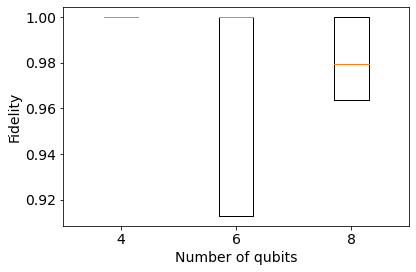

In [15]:
import matplotlib.pyplot as plt 
# Option 1
plt.rcParams['font.size'] = 14

fidelity_dict = load_obj("sz=4XXZSteadyStateFidelities")
data = list(fidelity_dict.values())
# means = [np.mean(x) for x in data]
# std_devs = [np.std(x) for x in data]
fig,ax = plt.subplots() 
# ax.scatter(range(len(means)),means)
# ax.errorbar(range(len(means)),means, yerr = std_devs, fmt = "o")
ax.boxplot(data, whis = 0, showfliers=0, meanline = True, labels = [4,6,8])
ax.set_ylabel("Fidelity")
ax.set_xlabel("Number of qubits")
plt.tight_layout()
plt.savefig("graphsforpaper/FidelityAgainstNumberOfQubits.pdf")